In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoModel, BertTokenizer
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm.auto import tqdm
import csv
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import time

In [2]:
class TextDataset(Dataset):
    def __init__(self, filepath, tokenizer, text_column, label_column, max_len):
        self.df = pd.read_csv(filepath)
        self.tokenizer = tokenizer
        self.text_column = text_column
        self.label_column = label_column
        self.max_len = max_len

        self.unique_labels = self.df[label_column].unique()
        self.label_map = {label: idx for idx, label in enumerate(self.unique_labels)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx][self.text_column]
        label_str = self.df.iloc[idx][self.label_column]
        label_int = self.label_map[label_str]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label_int, dtype=torch.long)
        }

In [3]:
class BertLSTM(nn.Module):
    def __init__(self, bert_model, lstm_hidden_dim, num_labels):
        super(BertLSTM, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(bert_model.config.hidden_size, lstm_hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(lstm_hidden_dim * 2, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        lstm_output, _ = self.lstm(sequence_output)
        logits = self.classifier(lstm_output[:, 0, :])
        return logits

In [4]:
# Define Focal Loss 
class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma, num_labels, reduction):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_labels = num_labels
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [5]:
# Record hyperparameters as csv
def write_hyperparameters(filepath, hyperparams):
    with open(filepath, mode='w', newline='') as file:  
        writer = csv.writer(file)
        writer.writerow(['Hyperparameters'])
        for key, value in hyperparams.items():
            writer.writerow([key, value])
        writer.writerow([])
        writer.writerow(['Epoch', 'Train Loss', 'Validation Loss', 'Validation Accuracy'])  

# Define hyperparameters
hyperparams = {
    'lstm_hidden_dim': 128,
    'max_len': 512,
    'batch_size': 8,
    'learning_rate': 5e-5,
    'num_epochs': 3,
    'alpha': 0.25,
    'gamma': 2.0,
    'reduction': 'mean'
}

In [6]:
# Load the pre-trained BERT model and Tokenizer
bert_model = AutoModel.from_pretrained('../Bert/FYP-Bert_model(multiple)')
tokenizer = BertTokenizer.from_pretrained('../Bert/FYP-Bert_model(multiple)')

# Create a dataset
dataset = TextDataset(
    filepath='../Web_scraping_and_Data_preproecssing/preprocessed_data.csv',
    tokenizer=tokenizer,
    text_column='Title_preprocessed',
    label_column='Classification',
    max_len=hyperparams['max_len']
)

# Split the data set
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create dataloader
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])

Some weights of BertModel were not initialized from the model checkpoint at ../Bert/FYP-Bert_model(multiple) and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Create model
num_labels = len(dataset.unique_labels)
model = BertLSTM(bert_model, hyperparams['lstm_hidden_dim'], num_labels)

#Create device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=hyperparams['learning_rate'])
criterion = FocalLoss(alpha=hyperparams['alpha'], gamma=hyperparams['gamma'], num_labels=num_labels, reduction=hyperparams['reduction'])

# CrossEntropyLoss function
#criterion = CrossEntropyLoss() 

In [9]:
# Define functions to train and evaluate models

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc='Training', leave=False)  
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'Loss': loss.item()})  
    average_loss = total_loss / len(train_loader)
    return average_loss

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted_labels = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(predicted_labels == labels).item()
    average_loss = total_loss / len(loader)
    accuracy = correct_predictions / len(loader.dataset)
    return average_loss, accuracy

In [10]:
# Record hyperparameters as csv
metrics_path = 'training_metrics(multiple).csv'
write_hyperparameters(metrics_path, hyperparams)

# Train and validate the model
num_epochs = hyperparams['num_epochs']
start_time = time.time()  
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    #Append performance metrics to csv file
    with open(metrics_path, mode='a', newline='') as metrics_file:
        metrics_writer = csv.writer(metrics_file)
        metrics_writer.writerow([epoch + 1, train_loss, val_loss, val_accuracy])

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

end_time = time.time()  
total_time = (end_time - start_time) / 60  

print(f'Total training time: {total_time:.2f} minutes')

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.5241, Validation Loss: 0.4315, Validation Accuracy: 0.4788


Training:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.3750, Validation Loss: 0.3748, Validation Accuracy: 0.5179


Training:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.2953, Validation Loss: 0.3609, Validation Accuracy: 0.5303
Total training time: 29.21 minutes


In [11]:
# 指定保存模型的文件路径
model_save_path = 'FYP_LSTM(multiple).pth'

# 保存整个模型
torch.save(model, model_save_path)


In [12]:
# Test the model
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Test Loss: 0.38239206546387133, Test Accuracy: 0.5029045643153527


In [13]:
import json

label_map_path = 'label_map.json'
with open(label_map_path, 'w') as file:
    json.dump(dataset.label_map, file)

print(f"Label map saved to {label_map_path}")

Label map saved to label_map.json


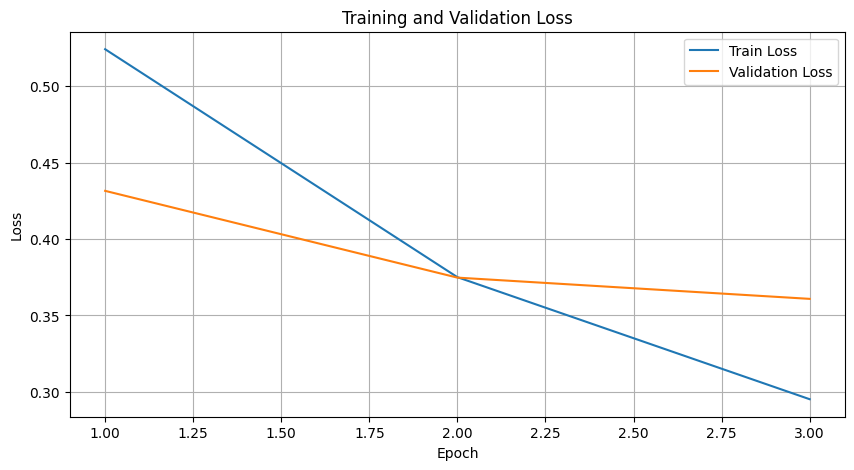

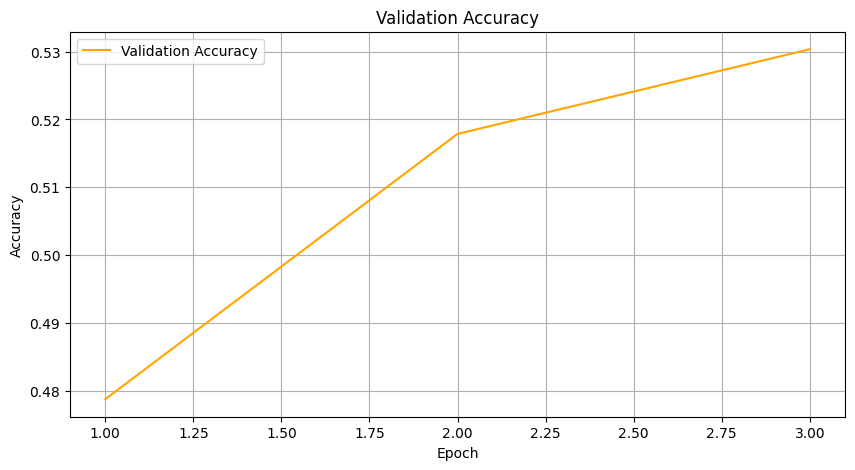

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

#Read performance metrics csv file
df = pd.read_csv('training_metrics(multiple).csv',header=9)

# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Draw model accuracy
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Validation Accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Use the model to predict

input_text = '有無人婚姻都唔開心？想去日本溝女如果有樓唔使供，但要同阿媽住，有冇女人願意嫁？'

# Use tokenizer to process input text
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)

input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(outputs, dim=1)
    predicted_class = predictions.item()  

label_map = {v: k for k, v in dataset.label_map.items()}  
predicted_label = label_map[predicted_class]
print("Predicted label:", predicted_label)

Predicted label: 感情台
